# Analysis of ECG Data to Diagnose Heart Arrhythmias

**Samer Najjar<br>
30 November 2021**

#### About my dataset
My dataset is about heart arrhythmias (irregular heartbeat). Each observation represents a patient, containing ECG values, the name of the patient's arrhythmia, and the heart condition(s) the patient has, if any.<br>
Dataset source: https://figshare.com/collections/ChapmanECG/4560497/2

#### Research question and learning model
I am trying to use the numeric ECG values of a patient to predict certain arrhythmias and/or heart conditions. Thus, I will use classification models. I will use _Logistic Regression_, _Support Vector Machine (SVM)_, _K-Nearest Neighbors (KNN)_, and _Decision Tree_ to predict certain selected heart conditions.

#### Evaluating the model
I will use a train/test split to train and test the model, then I will look at the accuracy, precision, and recall to evaluate the performance of the model. In medicine we really don't like false negatives, as an undiagnosed heart condition could be life-threatening, so the recall will be especially important. I relate to this personally; despite having multiple ECGs done on me, doctors failed to diagnose me until I had two cardiac arrests in one hour. I was extremely lucky to survive, but if I had been diagnosed earlier we could have avoided that which kills 475,000 Americans yearly.

#### My prediction
Based on what I've learned about cardiology, the ECG is fairly effective in diagnosing or partially diagnosing many heart conditions. Thus, I expect my models to have at least 80% accuracy at worst, and hopefully very few false negatives, i.e. high recall (although I'm not sure if I will be able to achieve a high enough recall for clinical use).

<hr>

## 0) Basic anatomy
In this project we are mainly concerned with diagnosing arrhythmogenic conditions related to the atriums (upper chambers) and the ventricles (lower chambers):

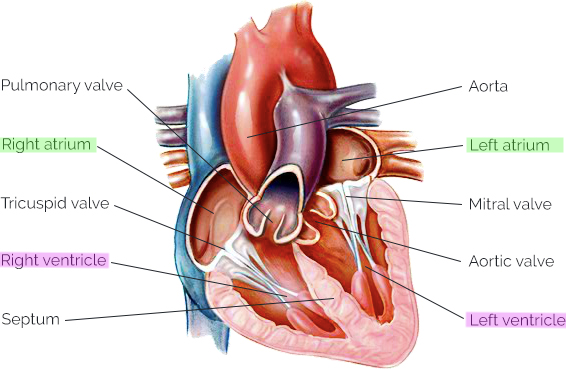
[ Source: https://yourheartvalve.com/heart-basics/heart-anatomy/ ]

<hr>

## 1) Prepare data

In [1]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, classification_report

from itertools import combinations

# Set random state for project (8)
RANDOM_STATE = 8

# Enable inline mode for matplotlib so that Jupyter displays graphs
%matplotlib inline

In [2]:
# Import dataset of ECG values and diagnostic info for various heart arrhythmias

arrhythmias = pd.read_excel('data/Diagnostics.xlsx')
arrhythmias

,FileName,Rhythm,Beat,PatientAge,Gender,VentricularRate,AtrialRate,QRSDuration,QTInterval,QTCorrected,RAxis,TAxis,QRSCount,QOnset,QOffset,TOffset
0,MUSE_20180113_171327_27000,AFIB,RBBB TWC,85,MALE,117,234,114,356,496,81,-27,19,208,265,386
1,MUSE_20180112_073319_29000,SB,TWC,59,FEMALE,52,52,92,432,401,76,42,8,215,261,431
2,MUSE_20180111_165520_97000,SA,NONE,20,FEMALE,67,67,82,382,403,88,20,11,224,265,415
3,MUSE_20180113_121940_44000,SB,NONE,66,MALE,53,53,96,456,427,34,3,9,219,267,447
4,MUSE_20180112_122850_57000,AF,STDD STTC,73,FEMALE,162,162,114,252,413,68,-40,26,228,285,354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10641,MUSE_20181222_204306_99000,SVT,NONE,80,FEMALE,196,73,168,284,513,258,244,32,177,261,319
10642,MUSE_20181222_204309_22000,SVT,NONE,81,FEMALE,162,81,162,294,482,110,-75,27,173,254,320
10643,MUSE_20181222_204310_31000,SVT,NONE,39,MALE,152,92,152,340,540,250,38,25,208,284,378
10644,MUSE_20181222_204312_58000,SVT,NONE,76,MALE,175,178,128,310,529,98,-83,29,205,269,360


In [3]:
# Show attribute info

attribute_info = pd.read_excel('data/AttributesDictionary.xlsx')
attribute_info

,Attributes,Type,ValueRange,Description
0,FileName,String,NaN,ECG data file name(unique ID)
1,Rhythm,String,NaN,Rhythm Label
2,Beat,String,NaN,Other conditions Label
3,PatientAge,Numeric,0-999,Age
4,Gender,String,MALE/FEMAL,Gender
5,VentricularRate,Numeric,0-999,Ventricular rate in BPM
6,AtrialRate,Numeric,0-999,Atrial rate in BPM
7,QRSDuration,Numeric -,0-999,QRS duration in msec
8,QTInterval,Numeric,0-999,QT interval in msec
9,QTCorrected,Numeric,0-999,Corrected QT interval in msec


In [4]:
# Check if columns have NaN values

print('Number of NaN values by column:\n')
for col in arrhythmias.columns:
    print(f'{col}: {arrhythmias[col].isnull().sum()}')

Number of NaN values by column:

FileName: 0
Rhythm: 0
Beat: 0
PatientAge: 0
Gender: 0
VentricularRate: 0
AtrialRate: 0
QRSDuration: 0
QTInterval: 0
QTCorrected: 0
RAxis: 0
TAxis: 0
QRSCount: 0
QOnset: 0
QOffset: 0
TOffset: 0


In [5]:
# No NaN values, so data is clean
# Drop FileName column

arrhythmias = arrhythmias.drop('FileName', axis=1).reset_index(drop=True)
arrhythmias

,Rhythm,Beat,PatientAge,Gender,VentricularRate,AtrialRate,QRSDuration,QTInterval,QTCorrected,RAxis,TAxis,QRSCount,QOnset,QOffset,TOffset
0,AFIB,RBBB TWC,85,MALE,117,234,114,356,496,81,-27,19,208,265,386
1,SB,TWC,59,FEMALE,52,52,92,432,401,76,42,8,215,261,431
2,SA,NONE,20,FEMALE,67,67,82,382,403,88,20,11,224,265,415
3,SB,NONE,66,MALE,53,53,96,456,427,34,3,9,219,267,447
4,AF,STDD STTC,73,FEMALE,162,162,114,252,413,68,-40,26,228,285,354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10641,SVT,NONE,80,FEMALE,196,73,168,284,513,258,244,32,177,261,319
10642,SVT,NONE,81,FEMALE,162,81,162,294,482,110,-75,27,173,254,320
10643,SVT,NONE,39,MALE,152,92,152,340,540,250,38,25,208,284,378
10644,SVT,NONE,76,MALE,175,178,128,310,529,98,-83,29,205,269,360


In [6]:
# Import dictionary for rhythm names

rhythm_names_df = pd.read_excel('data/RhythmNames.xlsx')
rhythm_names_df

,Acronym Name,Full Name
0,SB,Sinus Bradycardia
1,SR,Sinus Rhythm
2,AFIB,Atrial Fibrillation
3,ST,Sinus Tachycardia
4,AF,Atrial Flutter
5,SI,Sinus Irregularity
6,SVT,Supraventricular Tachycardia
7,AT,Atrial Tachycardia
8,AVNRT,Atrioventricular Node Reentrant Tachycardia
9,AVRT,Atrioventricular Reentrant Tachycardia


In [7]:
# Import dictionary for condition names

condition_names_df = pd.read_excel('data/ConditionNames.xlsx')
condition_names_df

,Acronym Name,Full Name
0,1AVB,1 degree atrioventricular block
1,2AVB,2 degree atrioventricular block
2,2AVB1,2 degree atrioventricular block(Type one)
3,2AVB2,2 degree atrioventricular block(Type two)
4,3AVB,3 degree atrioventricular block
5,ABI,atrial bigeminy
6,ALS,Axis left shift
7,APB,atrial premature beats
8,AQW,abnormal Q wave
9,ARS,Axis right shift


<hr>

## 2) Atrial Fibrilation (AFib)

AFib is an arrhythmia in which the atriums beat irregularly and rapidly. Usually AFib on its own is not deadly, but it increases the risk of stroke, heart failure, and other complications. It is the most commonly diagnosed arrhythmia and affects millions of Americans.
<br><br>
We will create a new dataframe aimed at predicting AFib from ECG values.

In [8]:
# See how many patients have AFib

arrhythmias['Rhythm'].value_counts()

SB       3889
SR       1826
AFIB     1780
ST       1568
SVT       587
AF        445
SA        399
AT        121
AVNRT      16
AVRT        8
SAAWR       7
Name: Rhythm, dtype: int64

In [9]:
# Create new dataframe aimed at predicting AFib

afib_df = arrhythmias.copy()
afib_df = afib_df.rename(columns={'Rhythm': 'AFib'})
afib_df['AFib'] = (afib_df['AFib'] == 'AFIB')

afib_df

,AFib,Beat,PatientAge,Gender,VentricularRate,AtrialRate,QRSDuration,QTInterval,QTCorrected,RAxis,TAxis,QRSCount,QOnset,QOffset,TOffset
0,True,RBBB TWC,85,MALE,117,234,114,356,496,81,-27,19,208,265,386
1,False,TWC,59,FEMALE,52,52,92,432,401,76,42,8,215,261,431
2,False,NONE,20,FEMALE,67,67,82,382,403,88,20,11,224,265,415
3,False,NONE,66,MALE,53,53,96,456,427,34,3,9,219,267,447
4,False,STDD STTC,73,FEMALE,162,162,114,252,413,68,-40,26,228,285,354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10641,False,NONE,80,FEMALE,196,73,168,284,513,258,244,32,177,261,319
10642,False,NONE,81,FEMALE,162,81,162,294,482,110,-75,27,173,254,320
10643,False,NONE,39,MALE,152,92,152,340,540,250,38,25,208,284,378
10644,False,NONE,76,MALE,175,178,128,310,529,98,-83,29,205,269,360


### Logistic Regression

In [10]:
# Build Logistic Regression model

# Select all numeric ECG values as features
all_features = [
    'VentricularRate',
    'AtrialRate',
    'QRSDuration',
    'QTInterval',
    'QTCorrected',
    'RAxis',
    'TAxis',
    'QRSCount',
    'QOnset',
    'QOffset',
    'TOffset'
]

X = afib_df[all_features]
y = afib_df['AFib']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [11]:
# Prints classification report in a convenient format (strictly for binary target)
def print_report(y_test, y_pred):
    # Accuracy
    print(f"accuracy = {sum(y_pred == y_test) / len(y_test)}")
    
    # precision = (True Positives) /  (True Positives + False Positives)
    # recall = (True Positives) / (True Positives + False Negatives)
    # F1-score = 2*((precision*recall)/(precision+recall))
    
    true_pos = false_pos = false_neg = 0

    for pred, true in zip(y_pred, y_test):
        if true == True and pred == True:
            true_pos += 1
        elif true == False and pred == True:
            false_pos += 1
        elif true == True and pred == False:
            false_neg += 1

    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    
    print(f'precision = {precision}')
    print(f'recall = {recall}')
    print(f'F1-score = {2 * ((precision*recall) / (precision+recall))}')

In [12]:
# Test model
    
y_pred = model.predict(X_test)
print_report(y_test, y_pred)

accuracy = 0.8474830954169797
precision = 0.6147540983606558
recall = 0.1728110599078341
F1-score = 0.2697841726618705


#### Interpretation:

The logistic regression model performed very poorly. Even though the model had 84% accuracy, a recall of 0.173 is far too low for any context, let alone a medical one. This means that the model was unable to diagnose most of the patients that actually had AFib. This may partially be due to the fact that, proportionally speaking, there are not many AFib-positive patients in the dataset.
<br><br>
We will try some other classification models to improve our performance.

### SVM

In [13]:
# Build and test SVM model

model = svm.SVC()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print_report(y_test, y_pred)

accuracy = 0.8534936138241923
precision = 0.7037037037037037
recall = 0.17511520737327188
F1-score = 0.28044280442804426


#### Interpretation:

This model also performs poorly.

### KNN

In [14]:
# Build and test KNN model

model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print_report(y_test, y_pred)

accuracy = 0.8741547708489857
precision = 0.6701030927835051
recall = 0.44930875576036866
F1-score = 0.5379310344827586


#### Interpretation:

This model performs a bit better but still not that well. However, instead of using all the features in the dataset, we can improve our performance by optimizing which features we use, and since KNN performed the best out of the three classifiers, we will try some optimization techniques on it. 

### Optimize KNN model
Test different combinations of numeric features and see which set of features produces the best model.

In [15]:
# Given a certain number of features n_features, this function finds the best set of features of size
# n_features that produces the highest accuracy model
def optimize_features(n_features, X, y, model, random_state=RANDOM_STATE):
    all_features = X.columns
    feature_combos = combinations(all_features, n_features)
    
    best_acc = 0
    best_features = None
    for features in feature_combos:
        features = list(features)
        
        X_train, X_test, y_train, y_test = train_test_split(X[features], y, test_size=0.25, random_state=random_state)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        acc = accuracy_score(y_test, y_pred)
        if acc > best_acc:
            best_features = features
            best_acc = acc
            
    return best_features, best_acc

In [16]:
# Instantiate new KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)
    
# Run the optimize_features function using various numbers of features (ranging from 1 to 11)
# NOTE: There are 11 total features, so this takes some time to run
for n in range(1, len(all_features) + 1):
    best_features, best_acc = optimize_features(n, X, y, knn_model)
    print(f'Optimal set of {n} feature{"" if n == 1 else "s"} (accuracy={best_acc}):')
    print(best_features)
    print()

Optimal set of 1 feature (accuracy=0.8377160030052592):
['QOffset']

Optimal set of 2 features (accuracy=0.9380165289256198):
['VentricularRate', 'AtrialRate']

Optimal set of 3 features (accuracy=0.9383921863260706):
['VentricularRate', 'AtrialRate', 'QRSCount']

Optimal set of 4 features (accuracy=0.9256198347107438):
['VentricularRate', 'AtrialRate', 'QRSCount', 'QOnset']

Optimal set of 5 features (accuracy=0.9158527422990232):
['VentricularRate', 'AtrialRate', 'QRSCount', 'QOnset', 'QOffset']

Optimal set of 6 features (accuracy=0.9064613072877535):
['VentricularRate', 'AtrialRate', 'QRSCount', 'QOnset', 'QOffset', 'TOffset']

Optimal set of 7 features (accuracy=0.8996994740796393):
['VentricularRate', 'AtrialRate', 'QTInterval', 'QTCorrected', 'QRSCount', 'QOffset', 'TOffset']

Optimal set of 8 features (accuracy=0.8974455296769346):
['VentricularRate', 'AtrialRate', 'QTInterval', 'QTCorrected', 'QRSCount', 'QOnset', 'QOffset', 'TOffset']

Optimal set of 9 features (accuracy=0.88

Based on the results, the optimal model (accuracy=0.938) uses the following 3 features:
* VentricularRate
* AtrialRate
* QRSCount

Now we see how the optimized model performs:

In [17]:
best_features = ['VentricularRate', 'AtrialRate', 'QRSCount']

X = afib_df[best_features]
y = afib_df['AFib']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

y_pred = knn_model.predict(X_test)
        
print_report(y_test, y_pred)

accuracy = 0.9383921863260706
precision = 0.8214285714285714
recall = 0.7949308755760369
F1-score = 0.8079625292740047


#### Interpretation:

This optimized KNN model is much better than the first three models. The accuracy was improved from 0.874 to 0.938, and more significantly, the recall was improved from 0.449 to 0.795 (the precision is also pretty good). Despite these big improvements in model performance, I don't think this model is quite ready for clinical implementation because it still misses quite a few AFib diagnoses; about 20% of patients with AFib were not diagnosed by this model. It may be a good model when someone's life isn't at risk, but in medicine, the model should be held to a higher standard. In conclusion, it's a fairly strong model but would require more improvement to be deployed in the real world.

<hr>

## 3) Predicting multiple heart rhythms

So far, I've used classification models to predict a binary target value (has AFib / doesn't have AFib). AFib is not the most concerning arrhythmia. In fact, generally speaking, arrhythmias of the ventricles are more deadly than atrial arrhythmias and can often cause cardiac arrest. For example, while atrial fibrillation often goes unnoticed, ventricular fibrilliation is highly fatal with a mortality rate of 90-95% if not treated immediately (ventricular fibrillation is the type of cardiac arrest I had). Some arrhythmias in this data set, such as supraventricular tachycardia (SVT) can lead to ventricular fibrillation. Thus, it would be useful to build a model that can predict multiple arrhythmias, both atrial and ventricular. For this, I will use a Decision Tree. I will use some optimization techniques such as optimizing the feature set (like before) and testing various max depths for the tree.

### Decision Tree

In [18]:
# The previous optimize_features function found the optimal set of features given a fixed number of
# features (dimension); this function finds the optimal number of features AND the optimal set of
# features of that size
def optimize_features_and_dimension(X, y, model, random_state=RANDOM_STATE):   
    best_acc = 0
    best_features = None
    
    for n in range(1, len(X.columns) + 1):
        features, acc = optimize_features(n, X, y, model)
        if acc > best_acc:
            best_features = features
            best_acc = acc
    
    return best_features

In [19]:
# Determine optimal feature set for Decision Tree model
# (takes some time to run)

X = arrhythmias[all_features]
y = arrhythmias['Rhythm']

tree_model = DecisionTreeClassifier(random_state=RANDOM_STATE)

best_features = optimize_features_and_dimension(X, y, tree_model)
best_features

['VentricularRate', 'AtrialRate']

In [20]:
# Build and test Decision Tree model

X_train, X_test, y_train, y_test = train_test_split(X[best_features], y, test_size=0.25, random_state=RANDOM_STATE)

# Test various max depths from 2 to 10 and select model with best accuracy
best_acc = 0
best_depth = 2
for depth in range(2, 11):
    tree_model.max_depth = depth
    tree_model.fit(X_train, y_train)
    
    y_pred = tree_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    
    if acc > best_acc:
        best_depth = depth
        best_acc = acc

# Build model with optimal max depth
tree_model.max_depth = best_depth
tree_model.fit(X_train, y_train)

y_pred = tree_model.predict(X_test)

print(f'max_depth = {tree_model.max_depth}\n')
print(classification_report(y_test, y_pred, digits=3, zero_division=0))

max_depth = 9

              precision    recall  f1-score   support

          AF      0.149     0.069     0.095       101
        AFIB      0.785     0.730     0.757       434
          AT      0.000     0.000     0.000        24
       AVNRT      0.000     0.000     0.000         6
        AVRT      0.000     0.000     0.000         1
          SA      0.000     0.000     0.000        89
       SAAWR      0.000     0.000     0.000         2
          SB      0.987     0.990     0.989      1006
          SR      0.750     0.996     0.856       459
          ST      0.905     0.963     0.933       404
         SVT      0.639     0.743     0.687       136

    accuracy                          0.852      2662
   macro avg      0.383     0.408     0.392      2662
weighted avg      0.806     0.852     0.825      2662



#### Interpretation:

Based on the classification report, it is clear that in many cases the Decision Tree did not do so well, with an accuracy of 0.852, a weighted average recall of 0.832, and bad F1-scores for most rhythms. I'm sure this is partly due to the fact that we have so many different arrhythmias but a relatively small dataset (in some cases we only have a few observations of a particular arrhythmia); notice how the rhythms with higher support (more observations) have better performance. For the last four heart rhythms (SB, SR, ST, SVT) the model was not so bad.
<br><br>
Instead of just looking at how accurate the model was in predicting each unique heart rhythm, I want to see how often the Decision Tree misclassifies an abnormal heart rhythm as normal (false negative). With previous classifiers, I did this by computing the recall score. However, since the Decision Tree is a multiclass classifier, I first need to map the heart rhythms to a binary value (True/False) and then fit the model again. This way, although the Decision Tree won't predict specific heart rhythms, it would at least predict when the heart rhythm is abnormal.
<br><br>
If you look at the rhythm names below, you will see one called "SR" which stands for "Sinus Rhythm". SR is a normal heart rhythm, so we will consider this as "doesn't have arrhythmia", i.e. `False`, and we will consider the other rhythms as "has arrhythmia", i.e `True`. The code below maps "SR" heart rhythms to `False` and all other rhythms to `True`.

In [21]:
# See all heart rhythms
rhythm_names_df

,Acronym Name,Full Name
0,SB,Sinus Bradycardia
1,SR,Sinus Rhythm
2,AFIB,Atrial Fibrillation
3,ST,Sinus Tachycardia
4,AF,Atrial Flutter
5,SI,Sinus Irregularity
6,SVT,Supraventricular Tachycardia
7,AT,Atrial Tachycardia
8,AVNRT,Atrioventricular Node Reentrant Tachycardia
9,AVRT,Atrioventricular Reentrant Tachycardia


In [22]:
# Map rhythms to binary outcome
y_binary = (y != 'SR')

In [23]:
# Build and test Decision Tree model

binary_tree_model = DecisionTreeClassifier(random_state=RANDOM_STATE)

# Use best_features from before (VentricularRate and AtrialRate)
X_train, X_test, y_train, y_test = train_test_split(X[best_features], y_binary, test_size=0.25, random_state=RANDOM_STATE)

# Test various max depths from 2 to 10 and select model with best accuracy
best_acc = 0
best_depth = 2
for depth in range(2, 11):
    binary_tree_model.max_depth = depth
    binary_tree_model.fit(X_train, y_train)
    
    y_pred = binary_tree_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    
    if acc > best_acc:
        best_depth = depth
        best_acc = acc

# Build model with optimal max depth
binary_tree_model.max_depth = best_depth
binary_tree_model.fit(X_train, y_train)

y_pred = binary_tree_model.predict(X_test)

print(f'max_depth = {binary_tree_model.max_depth}\n')
print_report(y_test, y_pred)

max_depth = 10

accuracy = 0.941397445529677
precision = 0.9990248659190639
recall = 0.9300953245574217
F1-score = 0.9633286318758816


#### Interpretation:

Now we have a pretty strong tree model with an accuracy of 0.941 and a recall score of 0.930, compared with those of the multiclass Decision Tree (0.852 for both accuracy and weighted average recall). The recall score of the binary Decision Tree is also much better than the recall score of the KNN model (0.795); so, while the KNN model failed to diagnose about 20% of AFib patients, the binary Decision Tree only failed to recognize about 7% of patients as having abnormal heart rhythms, even if it couldn't always tell exactly which arrhythmia it was. It may be unfair to compare the two models since the KNN model was focused on AFib while the binary Decision Tree clumped all arrhythmias into one group, but in any case the binary Decision Tree performed pretty well (much better than the multiclass Decision Tree).
<br><br>
Now, ideally, I'd want the accuracy to be at least 95% and the recall to be closer to 100% before I can comfortably say it is ready for clinical implementation; however, if any of our models are to be clinically deployed, it is definitely the binary Decision Tree. It performs very well and its numbers would be considered great in many contexts, but I still think it needs a little more improvement before it can be used medically.
<br><br>
I think it's worth noting that usually the benefit of the Decision Tree is that it can predict many different classes, as opposed to just one. We did not take advantage of this in the binary Decision Tree, and instead we made it easier for the model to correctly predict if some abnormality exists. The model is still worth something, but a truly sophisticated model would be able to do both: predict multiple heart rhythms AND perform with very high accuracy and recall.

<hr>

## 4) Conclusion

To summarize, we developed three promising models:

1. **KNN** - predicts AFib
    * accuracy = 0.938
    * recall = 0.795
    * Performs with high accuracy, but needs a significantly higher recall score to be considered for clinical use.
   
   
2. **Multiclass Decision Tree** - predicts multiple heart rhythms
    * accuracy = 0.852
    * weighted average recall = 0.852
    * Overall accuracy is not horrible but should be improved. Performs very poorly for some rhythms, and pretty well for other rhythms; a larger dataset would improve performance for more heart rhythms. Not ready for clinical use, unless we cut out the rhythms for which the model performs poorly.
    
    
3. **Binary Decision Tree** - predicts abnormal heart rhythm
    * accuracy = 0.941
    * recall = 0.930
    * Performs with high accuracy and high recall; best candidate for clinical use. Still needs a little improvement in recall score (ideally >95%) to truly be ready for clinical use.

In [24]:
knn_model  # predicts AFib
tree_model  # predicts multiple heart rhythms
binary_tree_model  # predicts abnormal heart rhythm

pass